In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import libraries - PyTorch

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tempfile import TemporaryDirectory
import time

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.models import resnet101, resnet50, resnet18
import torchvision.transforms as transforms
import torchvision.transforms as tt
from torchvision.datasets import CIFAR100 
from torchvision import datasets, models, transforms
from torchinfo import summary

from tqdm import tqdm

In [34]:
torch.manual_seed(0)

In [ ]:
!rm -rf /kaggle/working/*
!rm -rf /kaggle/working/models/*

In [35]:
os.makedirs("/kaggle/working/models",exist_ok=True)

In [36]:
os.makedirs("/kaggle/working/aftermodels",exist_ok=True)

# Compute stats

In [ ]:
stat_train_data = CIFAR100(download=True, root="./data", transform=tt.ToTensor())
stat_test_data = CIFAR100(root="./data", train=False, transform=tt.ToTensor())

In [ ]:
imgs_train = torch.stack([img_t for img_t ,_ in stat_train_data],dim=3)
imgs_test = torch.stack([img_t for img_t ,_ in stat_test_data],dim=3)
imgs = torch.cat((imgs_train, imgs_test), 3)
mean = imgs.view(3,-1).mean(dim=1).numpy()
std = imgs.view(3, -1).std(dim=1).numpy()
print(mean, std)

# Stat and transform

In [5]:
stats=((0.50736207, 0.4866896, 0.44108862), (0.26748815, 0.2565931, 0.2763085))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# Import dataset 100 classes

In [6]:
train_data = CIFAR100(download=True, root="./data", transform=train_transform)
test_data = CIFAR100(root="./data", train=False, transform=test_transform)

100%|██████████| 169001437/169001437 [00:02<00:00, 80375487.84it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [7]:
batch_size=128
num_work=4
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)

# Import dataset 20 classes

In [8]:
class CIFAR100Coarse(torch.utils.data.Dataset):
    def __init__(self, cifar100_dataset) ->None:
        self.cifar100_dataset = cifar100_dataset
        
        # Define the mapping from fine labels to coarse labels
        self.fine_to_coarse={
            0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3,
            10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7,
            19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15,
            28: 3, 29: 15, 30: 0, 31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16,
            37: 9, 38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13,
            46: 14, 47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2,
            55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
            64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0,
            73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19,
            82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18, 91: 1,
            92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13
        }
        
        # Mapping from superclass labels to superclass names
        self.coarse_label_names = {
            0: 'aquatic mammals',
            1: 'fish',
            2: 'flowers',
            3: 'food containers',
            4: 'fruit and vegetables',
            5: 'household electrical devices',
            6: 'household furniture',
            7: 'insects',
            8: 'large carnivores',
            9: 'large man-made outdoor things',
            10: 'large natural outdoor scenes',
            11: 'large omnivores and herbivores',
            12: 'medium-sized mammals',
            13: 'non-insect invertebrates',
            14: 'people',
            15: 'reptiles',
            16: 'small mammals',
            17: 'trees',
            18: 'vehicles 1',
            19: 'vehicles 2'
        }

    def __getitem__(self, index):
        img, target = self.cifar100_dataset[index]

        # Convert fine label to coarse label
        target = self.fine_to_coarse[target]

        return img, target

    def __len__(self):
        return len(self.cifar100_dataset)

    def get_coarse_label_name(self, label):
        return self.coarse_label_names[label]

    def get_all_coarse_label_names(self):
        return self.coarse_label_names.values()


In [37]:
train_data_20=CIFAR100Coarse(train_data)
test_data_20=CIFAR100Coarse(test_data)

In [38]:
def get_superclass(targets):
    fine_to_coarse={
            0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3,
            10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7,
            19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15,
            28: 3, 29: 15, 30: 0, 31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16,
            37: 9, 38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13,
            46: 14, 47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2,
            55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
            64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0,
            73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19,
            82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18, 91: 1,
            92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13
        }
    targets_cpu=targets.cpu().numpy()
    supertargets=[fine_to_coarse[target] for target in targets_cpu]
    supertargets=torch.tensor(supertargets, dtype=torch.int64, device=targets.device)
    return supertargets

In [39]:
fine_to_coarse={
            0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3,
            10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7,
            19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15,
            28: 3, 29: 15, 30: 0, 31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16,
            37: 9, 38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13,
            46: 14, 47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2,
            55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
            64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0,
            73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19,
            82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18, 91: 1,
            92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13
        }

In [41]:
def get_superclass_logits(outputs, fine_to_coarse):
    num_superclasses = len(set(fine_to_coarse.values())) # 20 superclass
    superclass_logits = torch.zeros((outputs.size(0), num_superclasses)).to(outputs.device)
    for fine_class, coarse_class in fine_to_coarse.items():
        superclass_logits[:, coarse_class] += outputs[:, fine_class] 
    return superclass_logits

In [42]:
batch_size=128
num_work=4
train_dl_20 = DataLoader(train_data_20, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)
test_dl_20 = DataLoader(test_data_20, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)

## Print number of items for each superclass

In [ ]:
train_classes_20={}

for img,label in train_data_20:
    class_name=train_data_20.coarse_label_names[label]
    if class_name not in train_classes_20:
        train_classes_20[class_name]=1
    else:
        train_classes_20[class_name]+=1

In [ ]:
train_classes_20

# Device - GPU cuda

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model

In [ ]:
def make_model(num_classes=20):
    model=resnet18(weights=None)
    model.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
    model.maxpool = nn.Identity()
    num_in_ftrs=model.fc.in_features
    num_out_ftrs=model.fc.out_features
    model.fc=nn.Linear(num_in_ftrs,num_classes)
    return model

In [55]:
model=resnet18(weights=None)
model.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
model.maxpool = nn.Identity()
num_in_ftrs=model.fc.in_features
num_out_ftrs=model.fc.out_features

In [56]:
num_classes=100
model.fc=nn.Linear(num_in_ftrs,num_classes)

In [57]:
model=model.to(device)

In [58]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [18]:
summary(model,(128,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 100]                --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─ReLU: 1-3                              [128, 64, 32, 32]         --
├─Identity: 1-4                          [128, 64, 32, 32]         --
├─Sequential: 1-5                        [128, 64, 32, 32]         --
│    └─BasicBlock: 2-1                   [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─ReLU: 3-3                    [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 32, 32]         128
│    │    └─ReLU: 3-6                    [128, 64, 32, 32]         --
│

# Optimizer, scheduler, criterion

In [59]:
# For optimizer:
max_lr=5e-2
momentum=0.9
weight_decay = 5e-4 
criterion_class = nn.CrossEntropyLoss()
criterion_superclass = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 25], gamma=0.1)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,55,60,80,120,140], gamma=0.1)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,80,120,140], gamma=0.2)

In [60]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, min_lr=5e-05, verbose=True)

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.3)

# Training and validation loop

In [61]:
num_epochs=300

In [ ]:
!rm -rf /kaggle/working/models/*

In [25]:
    for batch_idx, (inputs, targets) in enumerate(train_dl):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model(inputs)
        print(outputs.size())
        print(outputs[0])
        print(torch.argmax(outputs[0]))
        # First loss for normal classes
        loss_class = criterion_class(outputs, targets)
        # Changing the output and targets into superclasses and loss for superclasses
        super_targets=get_superclass(targets)
        outputs_superclass=get_superclass_logits(outputs, fine_to_coarse)
        print(outputs_superclass.size())
        print(outputs_superclass[0])
        print(torch.argmax(outputs_superclass[0]))
        
        
        loss_superclass=criterion_superclass(outputs_superclass,super_targets)
        
        # Sum loss function
        loss=loss_class+loss_superclass
        break

torch.Size([128, 100])
tensor([ 0.8376,  0.6942, -0.1024, -0.9487, -0.8250,  0.6479,  0.8322, -0.4381,
         0.5360, -0.0619, -0.7053,  0.4470,  0.1035, -0.2056,  0.0135,  0.9355,
         1.0547, -0.0802, -1.1413,  0.0753, -0.3321, -0.2254, -0.1519,  0.1125,
         0.2281, -0.4281,  0.2159,  1.0451, -0.7019, -0.6949,  0.9760,  1.4351,
        -1.0068, -0.9693, -1.7200,  0.8763,  0.8376,  0.2736,  1.4148, -0.3775,
         0.2546, -0.0961,  0.3980, -0.9084,  0.7617,  0.0088, -0.2845, -1.3432,
        -0.7838, -0.8538,  0.2867,  0.3438, -1.1419, -1.0494, -0.6548, -0.8230,
        -0.7822,  0.7746, -0.7293,  0.1443,  0.0750,  0.8942, -1.1395,  0.3305,
        -0.4966,  0.4535,  0.0544, -1.0685, -0.8026,  0.0900, -1.5918, -2.4022,
         0.1232,  1.9588, -0.0139, -0.9211, -1.3188, -0.8549, -0.5399,  0.8168,
        -0.3122,  0.5297,  0.2895,  1.4297, -0.3240,  1.0606,  0.2818, -2.6332,
        -0.3728, -1.2851,  1.2004, -0.2224,  0.6713, -0.1274,  0.8875, -0.6126,
         0.5417, 

In [32]:
print(outputs_single_row[0],outputs_single_row[51],outputs_single_row[53],outputs_single_row[57],outputs_single_row[83])
outputs_single_row[0]+outputs_single_row[51]+outputs_single_row[53]+outputs_single_row[57]+outputs_single_row[83]

tensor(0.8376) tensor(0.3438) tensor(-1.0494) tensor(0.7746) tensor(1.4297)


tensor(2.3363)

# Train for 100 classes with aditional criterion for 20 superclasses

In [ ]:
train_loss=[]
train_loss_class=[]
train_loss_superclass=[]
train_acc=[]
train_acc_super=[]
test_loss=[]
test_loss_class=[]
test_loss_superclass=[]
test_acc=[]
test_acc_super=[]

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_loss_class=0.0
    total_loss_superclass=0.0
    correct_predictions = 0
    total_samples = 0
    correct_predictions_super=0
    total_samples_super=0

    data_loader = tqdm(train_dl, total=len(train_dl), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model(inputs)
        # First loss for normal classes
        loss_class = criterion_class(outputs, targets)
        # Changing the output and targets into superclasses and loss for superclasses
        super_targets=get_superclass(targets)
        outputs_superclass=get_superclass_logits(outputs, fine_to_coarse)
        loss_superclass=criterion_superclass(outputs_superclass,super_targets)
        
        # Sum loss function
        loss=loss_class+loss_superclass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_loss_class+=loss_class.item()
        total_loss_superclass+=loss_superclass.item()

        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)
        
        _,predicted_superclass=outputs_superclass.max(1)
        correct_predictions_super+=predicted_superclass.eq(super_targets).sum().item()
        total_samples_super+=super_targets.size(0)
        

        # Progress bar description
        data_loader.set_postfix(loss=total_loss / (batch_idx + 1), Loss_class=total_loss_class/(batch_idx + 1), Loss_superclass=total_loss_superclass/(batch_idx + 1),
                                accuracy=correct_predictions / total_samples, accuracy_super=correct_predictions_super/total_samples_super)

    average_loss = total_loss / len(train_dl)
    average_loss_class=total_loss_class/(batch_idx + 1)
    average_loss_superclass=total_loss_superclass/(batch_idx + 1)
    accuracy = correct_predictions / total_samples
    accuracy_super=correct_predictions_super/total_samples_super

    train_loss.append(average_loss)
    train_loss_class.append(average_loss_class)
    train_loss_superclass.append(average_loss_superclass)
    train_acc.append(accuracy)
    train_acc_super.append(accuracy_super)
    
    # test the model
    correct_test, total_test, total_loss_test = 0, 0, 0
    total_loss_class_test, total_loss_superclass_test=0,0
    correct_test_super, total_test_super =0,0
    with torch.no_grad():
        for (inputs, targets) in test_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss_class = criterion_class(outputs, targets)
            super_targets=get_superclass(targets)
            outputs_superclass=get_superclass_logits(outputs, fine_to_coarse)
            loss_superclass=criterion_superclass(outputs_superclass,super_targets)
            
            loss=loss_class+loss_superclass 
            total_loss_test += loss.item()
            total_loss_class_test +=loss_class.item()
            total_loss_superclass_test +=loss_superclass.item()
            
            __, predicted = outputs.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test+= targets.size(0)
            
            _,predicted_superclass=outputs_superclass.max(1)
            correct_test_super+=predicted_superclass.eq(super_targets).sum().item()
            total_test_super+=super_targets.size(0)

        accuracy_test = correct_test / total_test
        accuracy_test_super=correct_test_super/total_test_super
        average_loss_test = total_loss_test / len(test_dl)
        average_loss_class_test=total_loss_class_test/(batch_idx + 1)
        average_loss_superclass_test=total_loss_superclass_test/(batch_idx + 1)
   
    test_loss.append(average_loss_test)
    test_loss_class.append(average_loss_class_test)
    test_loss_superclass.append(average_loss_superclass_test)
    test_acc.append(accuracy_test)
    test_acc_super.append(accuracy_test_super)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f},Loss_class: {average_loss_class:.4f},Loss_superclass: {average_loss_superclass:.4f},Accuracy: {accuracy * 100:.2f}%, Accuracy_super: {accuracy_super * 100:.2f}%, Loss_test: {average_loss_test:.4f},Loss_test_class: {average_loss_class_test:.4f},Loss_test_superclass: {average_loss_superclass_test:.4f}, Accuracy_test: {100 * accuracy_test:.2f} %, Accuracy_test_super: {100 * accuracy_test_super:.2f} %')


#     if epoch%5==0:
#         model_save_path = '/kaggle/working/resnet_cifar100_100classes_e' + str(epoch+1) + '.pth'
#         training_stats = {
#           'epoch': epoch+1,
#           'model_state_dict': model.state_dict(),
#           'optimizer_state_dict': optimizer.state_dict(),
#           'scheduler_state_dict': scheduler.state_dict(),
#           'loss': average_loss,
#           'accuracy': accuracy,
#           'test_accuracy': accuracy_test,
#           'test_loss': average_loss_test,
#           'learning_rate': optimizer.param_groups[0]["lr"]
#         }
    model_save_path = '/kaggle/working/resnet_cifar100_100classes_e' + str(epoch+1) + '.pth'
    training_stats = {
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': average_loss,
        'loss_class': average_loss_class,
        'loss_superclass':average_loss_superclass,
        'accuracy': accuracy,
        'accuracy_super': accuracy_super,
        'test_accuracy': accuracy_test,
        'test_accuracy_super':accuracy_test_super,
        'test_loss': average_loss_test,
        'test_loss_class':average_loss_class_test,
        'test_loss_superclass':average_loss_superclass_test,
        'learning_rate': optimizer.param_groups[0]["lr"]
    }
    scheduler.step(average_loss_test)
    torch.save(training_stats, model_save_path)

Epoch [1/300]: 100%|██████████| 391/391 [00:37<00:00, 10.46it/s, Loss_class=4.47, Loss_superclass=3.01, accuracy=0.0344, accuracy_super=0.126, loss=7.49] 


Epoch [1/300] - Loss: 7.4870,Loss_class: 4.4726,Loss_superclass: 3.0144,Accuracy: 3.44%, Accuracy_super: 12.56%, Loss_test: 6.8516,Loss_test_class: 0.8591,Loss_test_superclass: 0.5252, Accuracy_test: 5.63 %, Accuracy_test_super: 18.40 %


Epoch [2/300]: 100%|██████████| 391/391 [00:37<00:00, 10.47it/s, Loss_class=4.12, Loss_superclass=2.54, accuracy=0.0735, accuracy_super=0.216, loss=6.66]


Epoch [2/300] - Loss: 6.6598,Loss_class: 4.1211,Loss_superclass: 2.5387,Accuracy: 7.35%, Accuracy_super: 21.63%, Loss_test: 6.4275,Loss_test_class: 0.8043,Loss_test_superclass: 0.4943, Accuracy_test: 10.21 %, Accuracy_test_super: 24.95 %


Epoch [3/300]: 100%|██████████| 391/391 [00:36<00:00, 10.59it/s, Loss_class=3.89, Loss_superclass=2.36, accuracy=0.117, accuracy_super=0.274, loss=6.25]


Epoch [3/300] - Loss: 6.2517,Loss_class: 3.8938,Loss_superclass: 2.3579,Accuracy: 11.74%, Accuracy_super: 27.44%, Loss_test: 5.9463,Loss_test_class: 0.7549,Loss_test_superclass: 0.4466, Accuracy_test: 15.67 %, Accuracy_test_super: 32.20 %


Epoch [4/300]: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s, Loss_class=3.65, Loss_superclass=2.19, accuracy=0.167, accuracy_super=0.337, loss=5.83]


Epoch [4/300] - Loss: 5.8349,Loss_class: 3.6452,Loss_superclass: 2.1896,Accuracy: 16.66%, Accuracy_super: 33.73%, Loss_test: 5.5944,Loss_test_class: 0.7026,Loss_test_superclass: 0.4277, Accuracy_test: 19.59 %, Accuracy_test_super: 35.77 %


Epoch [5/300]: 100%|██████████| 391/391 [00:37<00:00, 10.55it/s, Loss_class=3.39, Loss_superclass=2.04, accuracy=0.214, accuracy_super=0.382, loss=5.42]


Epoch [5/300] - Loss: 5.4244,Loss_class: 3.3879,Loss_superclass: 2.0365,Accuracy: 21.45%, Accuracy_super: 38.21%, Loss_test: 5.0954,Loss_test_class: 0.6482,Loss_test_superclass: 0.3813, Accuracy_test: 25.03 %, Accuracy_test_super: 42.37 %


Epoch [6/300]: 100%|██████████| 391/391 [00:36<00:00, 10.61it/s, Loss_class=3.09, Loss_superclass=1.85, accuracy=0.271, accuracy_super=0.441, loss=4.94]


Epoch [6/300] - Loss: 4.9415,Loss_class: 3.0892,Loss_superclass: 1.8523,Accuracy: 27.08%, Accuracy_super: 44.14%, Loss_test: 4.4944,Loss_test_class: 0.5715,Loss_test_superclass: 0.3366, Accuracy_test: 32.05 %, Accuracy_test_super: 48.98 %


Epoch [7/300]: 100%|██████████| 391/391 [00:37<00:00, 10.50it/s, Loss_class=2.75, Loss_superclass=1.64, accuracy=0.336, accuracy_super=0.504, loss=4.39]


Epoch [7/300] - Loss: 4.3929,Loss_class: 2.7534,Loss_superclass: 1.6395,Accuracy: 33.63%, Accuracy_super: 50.45%, Loss_test: 4.0503,Loss_test_class: 0.5152,Loss_test_superclass: 0.3032, Accuracy_test: 37.34 %, Accuracy_test_super: 54.02 %


Epoch [8/300]: 100%|██████████| 391/391 [00:37<00:00, 10.49it/s, Loss_class=2.47, Loss_superclass=1.47, accuracy=0.393, accuracy_super=0.552, loss=3.95]


Epoch [8/300] - Loss: 3.9479,Loss_class: 2.4740,Loss_superclass: 1.4739,Accuracy: 39.26%, Accuracy_super: 55.23%, Loss_test: 3.6264,Loss_test_class: 0.4572,Loss_test_superclass: 0.2755, Accuracy_test: 42.96 %, Accuracy_test_super: 59.02 %


Epoch [9/300]: 100%|██████████| 391/391 [00:37<00:00, 10.35it/s, Loss_class=2.24, Loss_superclass=1.33, accuracy=0.439, accuracy_super=0.596, loss=3.58]


Epoch [9/300] - Loss: 3.5758,Loss_class: 2.2448,Loss_superclass: 1.3310,Accuracy: 43.85%, Accuracy_super: 59.57%, Loss_test: 3.3775,Loss_test_class: 0.4289,Loss_test_superclass: 0.2536, Accuracy_test: 46.62 %, Accuracy_test_super: 61.99 %


Epoch [10/300]: 100%|██████████| 391/391 [00:37<00:00, 10.38it/s, Loss_class=2.07, Loss_superclass=1.23, accuracy=0.477, accuracy_super=0.628, loss=3.29]


Epoch [10/300] - Loss: 3.2933,Loss_class: 2.0672,Loss_superclass: 1.2261,Accuracy: 47.75%, Accuracy_super: 62.77%, Loss_test: 3.2395,Loss_test_class: 0.4082,Loss_test_superclass: 0.2463, Accuracy_test: 48.53 %, Accuracy_test_super: 62.58 %


Epoch [11/300]: 100%|██████████| 391/391 [00:37<00:00, 10.46it/s, Loss_class=1.91, Loss_superclass=1.12, accuracy=0.511, accuracy_super=0.657, loss=3.03]


Epoch [11/300] - Loss: 3.0327,Loss_class: 1.9098,Loss_superclass: 1.1229,Accuracy: 51.13%, Accuracy_super: 65.73%, Loss_test: 2.9984,Loss_test_class: 0.3767,Loss_test_superclass: 0.2291, Accuracy_test: 51.88 %, Accuracy_test_super: 65.40 %


Epoch [12/300]: 100%|██████████| 391/391 [00:37<00:00, 10.47it/s, Loss_class=1.81, Loss_superclass=1.07, accuracy=0.534, accuracy_super=0.673, loss=2.88]


Epoch [12/300] - Loss: 2.8761,Loss_class: 1.8068,Loss_superclass: 1.0694,Accuracy: 53.44%, Accuracy_super: 67.32%, Loss_test: 2.8457,Loss_test_class: 0.3591,Loss_test_superclass: 0.2158, Accuracy_test: 54.51 %, Accuracy_test_super: 68.06 %


Epoch [13/300]: 100%|██████████| 391/391 [00:37<00:00, 10.35it/s, Loss_class=1.71, Loss_superclass=1, accuracy=0.557, accuracy_super=0.696, loss=2.71]    


Epoch [13/300] - Loss: 2.7094,Loss_class: 1.7063,Loss_superclass: 1.0031,Accuracy: 55.71%, Accuracy_super: 69.59%, Loss_test: 2.8391,Loss_test_class: 0.3487,Loss_test_superclass: 0.2250, Accuracy_test: 55.01 %, Accuracy_test_super: 68.21 %


Epoch [14/300]: 100%|██████████| 391/391 [00:37<00:00, 10.48it/s, Loss_class=1.62, Loss_superclass=0.958, accuracy=0.577, accuracy_super=0.708, loss=2.58]


Epoch [14/300] - Loss: 2.5825,Loss_class: 1.6247,Loss_superclass: 0.9578,Accuracy: 57.68%, Accuracy_super: 70.75%, Loss_test: 2.6769,Loss_test_class: 0.3385,Loss_test_superclass: 0.2024, Accuracy_test: 55.98 %, Accuracy_test_super: 70.24 %


Epoch [15/300]: 100%|██████████| 391/391 [00:37<00:00, 10.35it/s, Loss_class=1.56, Loss_superclass=0.916, accuracy=0.593, accuracy_super=0.719, loss=2.47]


Epoch [15/300] - Loss: 2.4725,Loss_class: 1.5561,Loss_superclass: 0.9164,Accuracy: 59.32%, Accuracy_super: 71.86%, Loss_test: 2.6461,Loss_test_class: 0.3241,Loss_test_superclass: 0.2105, Accuracy_test: 57.65 %, Accuracy_test_super: 70.36 %


Epoch [16/300]: 100%|██████████| 391/391 [00:38<00:00, 10.27it/s, Loss_class=1.5, Loss_superclass=0.885, accuracy=0.604, accuracy_super=0.729, loss=2.39] 


Epoch [16/300] - Loss: 2.3856,Loss_class: 1.5003,Loss_superclass: 0.8853,Accuracy: 60.42%, Accuracy_super: 72.87%, Loss_test: 2.6035,Loss_test_class: 0.3254,Loss_test_superclass: 0.2006, Accuracy_test: 57.72 %, Accuracy_test_super: 70.33 %


Epoch [17/300]: 100%|██████████| 391/391 [00:38<00:00, 10.28it/s, Loss_class=1.43, Loss_superclass=0.844, accuracy=0.621, accuracy_super=0.742, loss=2.28]


Epoch [17/300] - Loss: 2.2789,Loss_class: 1.4345,Loss_superclass: 0.8444,Accuracy: 62.11%, Accuracy_super: 74.22%, Loss_test: 2.4957,Loss_test_class: 0.3128,Loss_test_superclass: 0.1914, Accuracy_test: 59.22 %, Accuracy_test_super: 72.07 %


Epoch [18/300]: 100%|██████████| 391/391 [00:37<00:00, 10.38it/s, Loss_class=1.39, Loss_superclass=0.818, accuracy=0.629, accuracy_super=0.75, loss=2.21] 


Epoch [18/300] - Loss: 2.2113,Loss_class: 1.3934,Loss_superclass: 0.8179,Accuracy: 62.93%, Accuracy_super: 75.00%, Loss_test: 2.5480,Loss_test_class: 0.3133,Loss_test_superclass: 0.2015, Accuracy_test: 58.89 %, Accuracy_test_super: 70.68 %


Epoch [19/300]: 100%|██████████| 391/391 [00:37<00:00, 10.36it/s, Loss_class=1.35, Loss_superclass=0.793, accuracy=0.641, accuracy_super=0.756, loss=2.15]


Epoch [19/300] - Loss: 2.1463,Loss_class: 1.3529,Loss_superclass: 0.7934,Accuracy: 64.09%, Accuracy_super: 75.60%, Loss_test: 2.4544,Loss_test_class: 0.2981,Loss_test_superclass: 0.1978, Accuracy_test: 60.71 %, Accuracy_test_super: 72.32 %


Epoch [20/300]: 100%|██████████| 391/391 [00:38<00:00, 10.25it/s, Loss_class=1.3, Loss_superclass=0.76, accuracy=0.653, accuracy_super=0.768, loss=2.06]  


Epoch [20/300] - Loss: 2.0586,Loss_class: 1.2989,Loss_superclass: 0.7596,Accuracy: 65.34%, Accuracy_super: 76.84%, Loss_test: 2.4842,Loss_test_class: 0.3003,Loss_test_superclass: 0.2016, Accuracy_test: 61.29 %, Accuracy_test_super: 72.19 %


Epoch [21/300]: 100%|██████████| 391/391 [00:37<00:00, 10.47it/s, Loss_class=1.26, Loss_superclass=0.739, accuracy=0.664, accuracy_super=0.773, loss=2]   


Epoch [21/300] - Loss: 2.0037,Loss_class: 1.2649,Loss_superclass: 0.7388,Accuracy: 66.39%, Accuracy_super: 77.32%, Loss_test: 2.4652,Loss_test_class: 0.3000,Loss_test_superclass: 0.1981, Accuracy_test: 60.85 %, Accuracy_test_super: 72.21 %


Epoch [22/300]: 100%|██████████| 391/391 [00:37<00:00, 10.44it/s, Loss_class=1.24, Loss_superclass=0.732, accuracy=0.668, accuracy_super=0.775, loss=1.97]


Epoch [22/300] - Loss: 1.9720,Loss_class: 1.2402,Loss_superclass: 0.7318,Accuracy: 66.82%, Accuracy_super: 77.47%, Loss_test: 2.3844,Loss_test_class: 0.2899,Loss_test_superclass: 0.1918, Accuracy_test: 61.28 %, Accuracy_test_super: 72.97 %


Epoch [23/300]: 100%|██████████| 391/391 [00:37<00:00, 10.43it/s, Loss_class=1.2, Loss_superclass=0.698, accuracy=0.676, accuracy_super=0.785, loss=1.9]  


Epoch [23/300] - Loss: 1.9024,Loss_class: 1.2040,Loss_superclass: 0.6985,Accuracy: 67.55%, Accuracy_super: 78.52%, Loss_test: 2.4112,Loss_test_class: 0.2938,Loss_test_superclass: 0.1934, Accuracy_test: 61.72 %, Accuracy_test_super: 73.53 %


Epoch [24/300]:  35%|███▍      | 135/391 [00:13<00:23, 10.91it/s, Loss_class=1.15, Loss_superclass=0.665, accuracy=0.688, accuracy_super=0.795, loss=1.82]

## Accuracy and loss plots

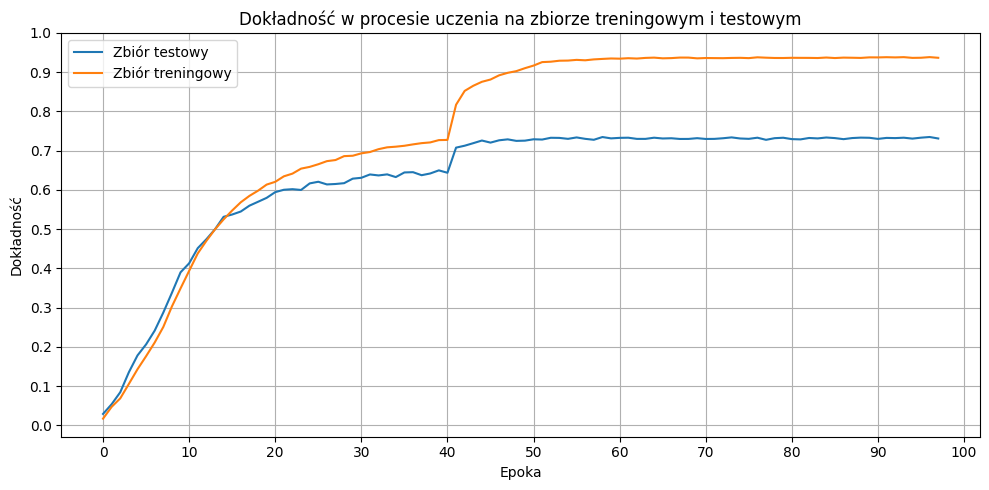

In [69]:
plt.figure(figsize=(10,5))
plt.title("Dokładność w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_acc[:101],label="Zbiór testowy")
plt.plot(train_acc[:101],label="Zbiór treningowy")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.xticks(np.arange(0,101,10))
plt.yticks(np.arange(0.0,1.1,0.1))
plt.grid()
plt.legend()
plt.savefig('cifar100_100classes_accuracyplot.png')
plt.tight_layout()
plt.show()

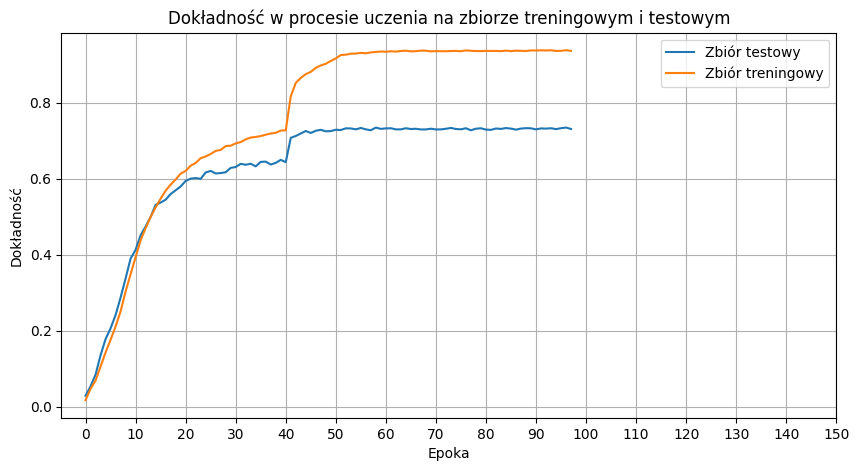

In [70]:
plt.figure(figsize=(10,5))
plt.title("Dokładność w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_acc[:151],label="Zbiór testowy")
plt.plot(train_acc[:151],label="Zbiór treningowy")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.xticks(np.arange(0,151,10))
plt.grid()
plt.legend()
plt.savefig('cifar100_20classes_accuracyplot_I.png')
plt.show()

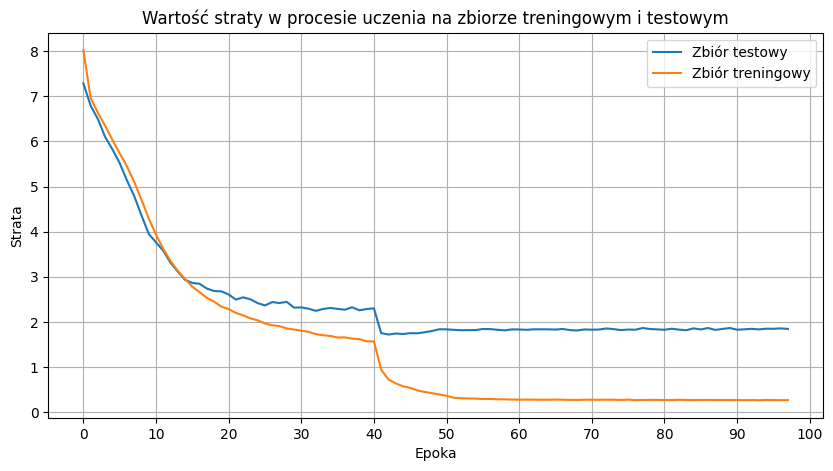

In [71]:
plt.figure(figsize=(10,5))
plt.title("Wartość straty w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_loss[:101],label="Zbiór testowy")
plt.plot(train_loss[:101],label="Zbiór treningowy")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.xticks(np.arange(0,101,10))
plt.grid()
plt.legend()
plt.savefig('cifar100_100classes_lossplot.png')
plt.show()

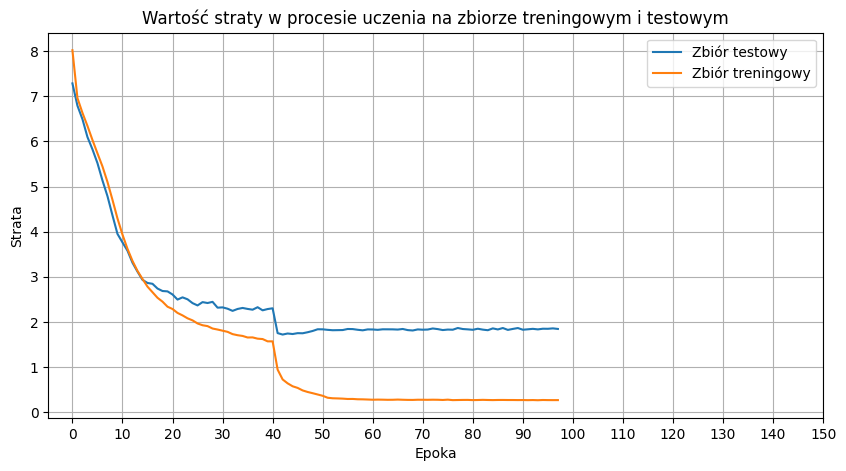

In [72]:
plt.figure(figsize=(10,5))
plt.title("Wartość straty w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_loss[:151],label="Zbiór testowy")
plt.plot(train_loss[:151],label="Zbiór treningowy")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.xticks(np.arange(0,151,10))
plt.grid()
plt.legend()
plt.savefig('cifar100_20classes_lossplot_I.png')
plt.show()

## Confusion matrix

In [ ]:
model.eval()
correct_test, total_test= 0, 0
all_preds = []
all_labels = []
with torch.no_grad():
    for (inputs, targets) in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        __, predicted = outputs.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f} %')

In [ ]:
all_preds_coarse=[]
for i in range(len(all_preds)):
    all_preds_coarse.append(train_data_20.fine_to_coarse[all_preds[i]])

all_labels_coarse=[]
for i in range(len(all_preds)):
    all_labels_coarse.append(train_data_20.fine_to_coarse[all_labels[i]])
    
cm=confusion_matrix(all_labels_coarse,all_preds_coarse)

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linecolor='black', linewidth=0.5)
plt.xlabel('Klasa przewidywana')
plt.ylabel('Klasa rzeczywista ')
plt.title('Macierz pomyłek')
plt.savefig('CM_100klas.png')
plt.show()

## Saving checkpoint separately

In [ ]:
model_save_path = '/kaggle/working/resnet_cifar100_' + str(87) + '.pth'
training_stats = {
  'epoch': epoch+1,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'scheduler_state_dict': scheduler.state_dict(),
  'loss': average_loss,
  'accuracy': accuracy,
  'test_accuracy': accuracy_test,
  'test_loss': average_loss_test,
  'learning_rate': optimizer.param_groups[0]["lr"]
}

In [ ]:
torch.save(training_stats, model_save_path)

# Retraining model for 100 classes

## Model setup

In [ ]:
saved_model_path='/kaggle/input/model-01/cifar100_20classes_ep53.pth'

In [ ]:
saved_model_path='/kaggle/input/pretrained-model/resnet_cifar100_transferlearningfor100clasep1415.pth'

In [ ]:
saved_model_path = '/kaggle/working/resnet_cifar100_87_20cl.pth'

In [ ]:
saved_model_path='/kaggle/input/premodel/resnet_cifar100_87_20cl.pth'

In [ ]:
saved_model_path='/kaggle/input/model25/resnet_cifar100_20classes_e25.pth'

In [ ]:
saved_model_path='/kaggle/working/models/resnet_cifar10_53.pth'

In [ ]:
model_test = resnet18(weights=None)

In [ ]:
model_test.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
model_test.maxpool=nn.Identity()
num_classes = 20
test_in_ftrs=model_test.fc.in_features
test_out_ftrs=model_test.fc.out_features
model_test.fc=nn.Linear(test_in_ftrs,num_classes)

## Model weights loading

In [ ]:
checkpoint = torch.load(saved_model_path)
model_test.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
for param in model_test.parameters():
    param.requires_grad = False

In [ ]:
for param in model_test.fc.parameters():
    param.requires_grad = True

In [ ]:
for name, param in model_test.named_parameters():
    print(name)

In [ ]:
for param in model_test.parameters():
    print(param.requires_grad)

In [ ]:
num_classes=100
model_test.fc = nn.Linear(test_in_ftrs, num_classes)

In [ ]:
model_test.to(device)

In [ ]:
model_test.eval().to(device)

### Evaluation for 20 classes

In [ ]:
model_test.eval()
correct_test, total_test= 0, 0
with torch.no_grad():
    for (inputs, targets) in test_dl_20:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_test(inputs)
        __, predicted = outputs.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f} %')

### Evaluation for 100 classes

In [ ]:
model_test.eval()
correct_test, total_test= 0, 0
with torch.no_grad():
    for (inputs, targets) in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_test(inputs)
        __, predicted = outputs.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f} %')

## Optimizer, scheduler etc.

In [ ]:
max_lr=5e-2
momentum=0.9
weight_decay = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_test.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
max_lr=1e-2
momentum=0.9
weight_decay = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_test.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
print([param.requires_grad for param in model_test.parameters()])

In [ ]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, min_lr=5e-05)

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,55,60,80,120,140], gamma=0.1)

In [ ]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
num_epochs=100
for epoch in range(num_epochs):
    model_test.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    data_loader = tqdm(test_dl, total=len(test_dl), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model_test(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)

        # Progress bar description
        data_loader.set_postfix(loss=total_loss / (batch_idx + 1), accuracy=correct_predictions / total_samples)

    average_loss = total_loss / len(test_dl)
    accuracy = correct_predictions / total_samples
    
    train_loss.append(average_loss)
    train_acc.append(accuracy)
    
    model_test.eval()
    # test the model
    correct_test, total_test, total_loss_test = 0, 0, 0
    with torch.no_grad():
        for (inputs, targets) in test_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_test(inputs)
            loss = criterion(outputs, targets)
            total_loss_test += loss.item()

            __, predicted = outputs.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test+= targets.size(0)

        accuracy_test = correct_test / total_test
        average_loss_test = total_loss_test / len(test_dl)
    
    test_loss.append(average_loss_test)
    test_acc.append(accuracy_test)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%, Loss on test data: {average_loss_test:.4f} Accuracy on test data: {100 * accuracy_test:.2f} %')

    model_save_path = '/kaggle/working/aftermodels/aftertl_100cl_ep' + str(epoch+1) + '.pth'
    training_stats = {
      'epoch': epoch+1,
      'model_state_dict': model_test.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler_state_dict': scheduler.state_dict(),
      'loss': average_loss,
      'accuracy': accuracy,
      'test_accuracy': accuracy_test,
      'test_loss': average_loss_test,
      'learning_rate': optimizer.param_groups[0]["lr"]
    }
        
    scheduler.step()
    torch.save(training_stats,model_save_path)

# Plots

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Testing Accuracy")
plt.plot(test_acc,label="Testing accuracy")
plt.plot(train_acc,label="Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Testing Loss")
plt.plot(test_loss,label="Testing loss")
plt.plot(train_loss,label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_test.eval()
ep=3
for e in range(ep):
    correct_test, total_test= 0, 0
    with torch.no_grad():
        for (inputs, targets) in test_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_test(inputs)
            __, predicted = outputs.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test+= targets.size(0)

    accuracy_test = correct_test / total_test
    accuracy_test_prc=accuracy_test*100
    print(f'Accuracy on test data: {accuracy_test_prc:.2f} %')

In [ ]:
model_save_path = '/kaggle/working/resnet_cifar100_transferlearningfor100clasep14' + str(epoch+1) + '.pth'

In [ ]:
training_stats = {
  'epoch': epoch+1,
  'model_state_dict': model_test.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'scheduler_state_dict': scheduler.state_dict(),
  'loss': average_loss,
  'accuracy': accuracy,
  'test_accuracy': accuracy_test,
  'test_loss': average_loss_test,
  'learning_rate': optimizer.param_groups[0]["lr"]
}

In [ ]:
torch.save(training_stats, model_save_path)